# Análisis Completo: Predicción de No-Show Médico

**Proyecto I - Especialización en Ciencia de Datos e IA**

## Objetivo
Predecir la probabilidad de que un paciente no asista a su cita médica, permitiendo a clínicas y hospitales optimizar sus recursos y reducir costos.

## 1. Importación de Librerías

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from src.data_loader import prepare_data
from src.preprocessing import (
    create_preprocessing_pipeline,
    prepare_features_target,
    get_feature_names
)
from src.synthetic_data import generate_synthetic_data, get_synthetic_data_stats
from src.models import (
    train_random_forest,
    train_logistic_regression,
    evaluate_model,
    get_feature_importance,
    compare_models,
    save_model
)
from src.visualization import (
    plot_target_distribution,
    plot_age_distribution,
    plot_noshow_by_feature,
    plot_correlation_matrix,
    plot_feature_importance,
    plot_model_comparison,
    plot_chronic_conditions
)

import warnings
warnings.filterwarnings('ignore')

## 2. Carga y Exploración de Datos

In [2]:
DATA_PATH = '../data/KaggleV2-May-2016.csv'

df, df_original = prepare_data(DATA_PATH)

df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,DaysAdvance,AppointmentWeekday,AppointmentMonth,ChronicConditionsCount
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,-1,4,4,1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,-1,4,4,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0,-1,4,4,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,-1,4,4,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0,-1,4,4,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110519 entries, 0 to 110526
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   PatientId               110519 non-null  float64            
 1   AppointmentID           110519 non-null  int64              
 2   Gender                  110519 non-null  category           
 3   ScheduledDay            110519 non-null  datetime64[ns, UTC]
 4   AppointmentDay          110519 non-null  datetime64[ns, UTC]
 5   Age                     110519 non-null  int64              
 6   Neighbourhood           110519 non-null  category           
 7   Scholarship             110519 non-null  int64              
 8   Hipertension            110519 non-null  int64              
 9   Diabetes                110519 non-null  int64              
 10  Alcoholism              110519 non-null  int64              
 11  Handcap                 110519 

In [4]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,DaysAdvance,AppointmentWeekday,AppointmentMonth,ChronicConditionsCount
count,1.105190e+05,1.105190e+05,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000
mean,1.474860e+14,5.675303e+06,37.084519,0.098273,0.197251,0.071870,0.030402,0.022213,0.321040,0.201920,9.183887,1.858251,5.210036,0.299523
std,2.560826e+14,7.129600e+04,23.103165,0.297684,0.397925,0.258274,0.171692,0.161441,0.466878,0.401435,15.255169,1.371657,0.473777,0.597669
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,4.000000,0.000000
25%,4.172457e+12,5.640284e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,5.000000,0.000000
50%,3.172598e+13,5.680569e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,5.000000,0.000000
75%,9.438963e+13,5.725522e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,3.000000,5.000000,0.000000
max,9.999816e+14,5.790484e+06,100.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,5.000000,6.000000,3.000000


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Distribución de la Variable Objetivo

In [5]:
fig = plot_target_distribution(df)
fig.show()

### 3.2 Distribución de Edades

In [6]:
fig = plot_age_distribution(df)
fig.show()

### 3.3 Condiciones Crónicas

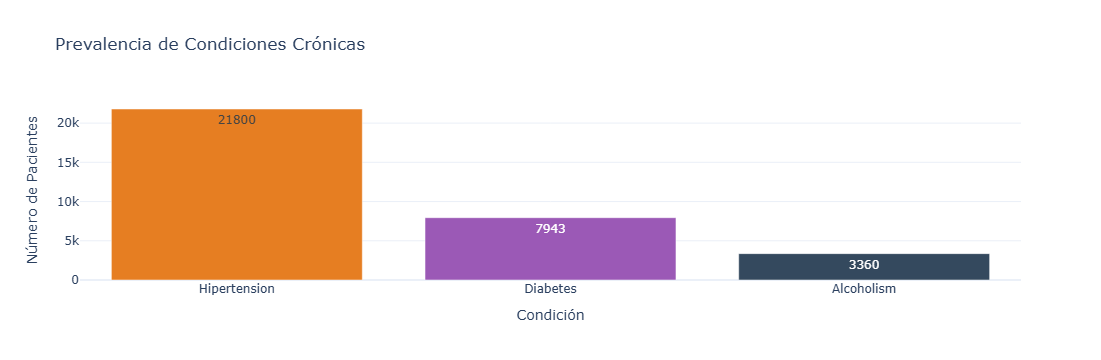

In [7]:
fig = plot_chronic_conditions(df)
fig.show()

### 3.4 Asistencia por Recepción de SMS

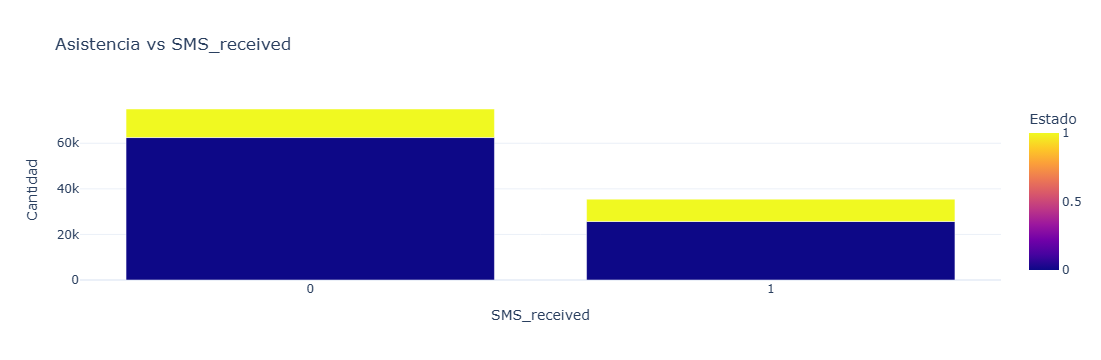

In [8]:
fig = plot_noshow_by_feature(df, 'SMS_received')
fig.show()

### 3.5 Matriz de Correlación

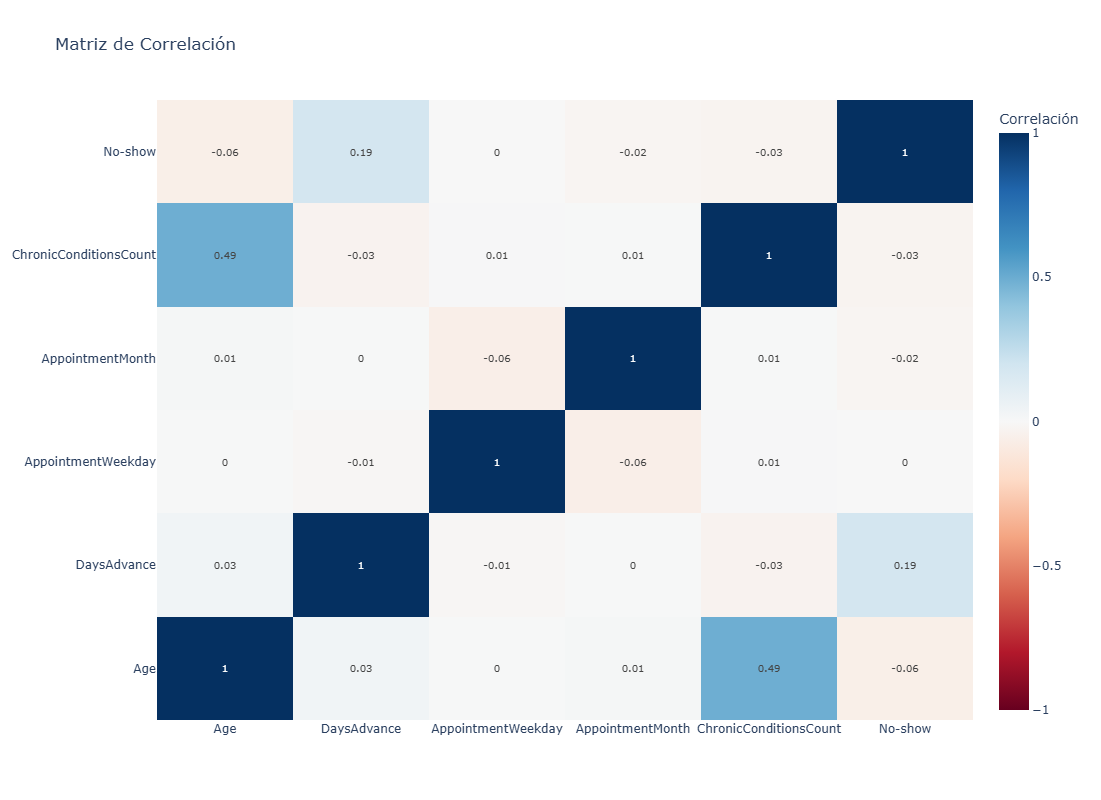

In [9]:
numeric_cols = ['Age', 'DaysAdvance', 'AppointmentWeekday', 'AppointmentMonth', 
                'ChronicConditionsCount', 'No-show']

fig = plot_correlation_matrix(df, numeric_cols)
fig.show()

## 4. Preparación de Datos

In [10]:
X, y = prepare_features_target(df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

f"Datos de entrenamiento: {X_train.shape[0]}, Datos de prueba: {X_test.shape[0]}"

'Datos de entrenamiento: 88415, Datos de prueba: 22104'

## 5. Pipeline de Preprocesamiento

In [11]:
preprocessor = create_preprocessing_pipeline()

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

f"Dimensión después del preprocesamiento: {X_train_processed.shape}"

'Dimensión después del preprocesamiento: (88415, 15)'

## 6. Generación de Datos Sintéticos (SMOTE)

In [12]:
X_train_synthetic, y_train_synthetic = generate_synthetic_data(
    X_train_processed, y_train
)

stats = get_synthetic_data_stats(
    X_train_processed, y_train,
    X_train_synthetic, y_train_synthetic
)

pd.DataFrame([stats]).T

,0
original_samples,88415
synthetic_samples,141124
original_class_0,70562
original_class_1,17853
synthetic_class_0,70562
synthetic_class_1,70562
samples_added,52709


## 7. Entrenamiento de Modelos

### 7.1 Modelos con Datos Originales

In [13]:
rf_original = train_random_forest(X_train_processed, y_train)
lr_original = train_logistic_regression(X_train_processed, y_train)

"Modelos entrenados con datos originales"

'Modelos entrenados con datos originales'

### 7.2 Modelos con Datos Sintéticos

In [14]:
rf_synthetic = train_random_forest(X_train_synthetic, y_train_synthetic)
lr_synthetic = train_logistic_regression(X_train_synthetic, y_train_synthetic)

"Modelos entrenados con datos sintéticos"

'Modelos entrenados con datos sintéticos'

## 8. Evaluación de Modelos

In [15]:
results = {
    'RF_Original': evaluate_model(rf_original, X_test_processed, y_test),
    'LR_Original': evaluate_model(lr_original, X_test_processed, y_test),
    'RF_Synthetic': evaluate_model(rf_synthetic, X_test_processed, y_test),
    'LR_Synthetic': evaluate_model(lr_synthetic, X_test_processed, y_test)
}

comparison_df = compare_models(results)
comparison_df

,accuracy,precision,recall,f1_score,roc_auc
RF_Original,0.7982,0.6000,0.0013,0.0027,0.7301
LR_Original,0.7954,0.3438,0.0148,0.0284,0.6641
RF_Synthetic,0.5760,0.3009,0.8311,0.4418,0.7237
LR_Synthetic,0.6655,0.3183,0.5749,0.4097,0.6692


In [16]:
fig = plot_model_comparison(comparison_df)
fig.show()

## 9. Importancia de Variables

In [17]:
feature_names = get_feature_names(preprocessor, X_train)

importance_df = get_feature_importance(rf_synthetic, feature_names, top_n=10)
importance_df

,feature,importance
1,DaysAdvance,0.759421
0,Age,0.100145
14,SMS_received_1,0.068381
2,AppointmentWeekday,0.019017
3,AppointmentMonth,0.009761
5,Gender_M,0.008435
6,Scholarship_1,0.008310
10,Handcap_1,0.008099
4,ChronicConditionsCount,0.005840
7,Hipertension_1,0.005736


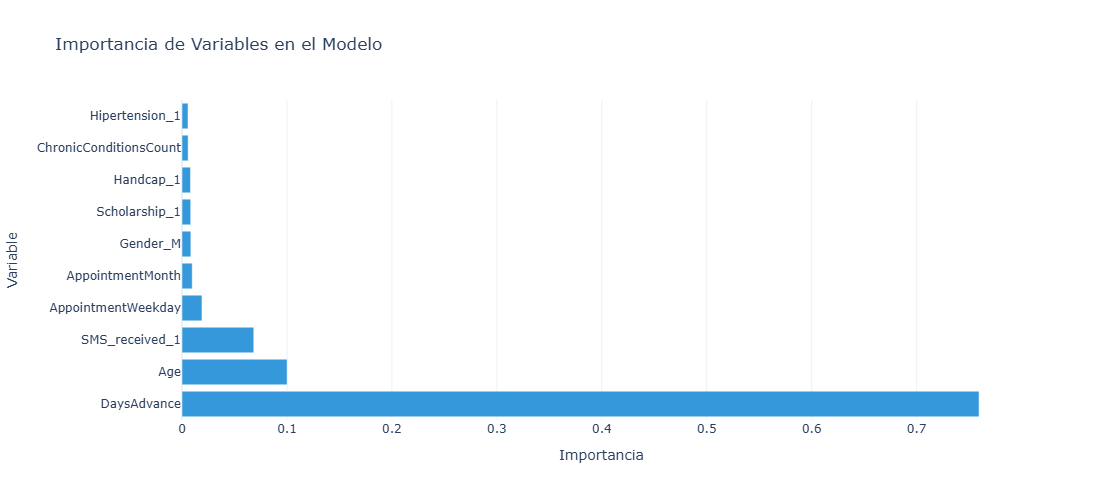

In [18]:
fig = plot_feature_importance(importance_df)
fig.show()

## 10. Guardar Modelos

In [19]:
save_model(rf_synthetic, '../models/random_forest_model.pkl')
save_model(lr_synthetic, '../models/logistic_regression_model.pkl')
save_model(preprocessor, '../models/preprocessor.pkl')

"Modelos guardados exitosamente"

'Modelos guardados exitosamente'

## 11. Conclusiones

### Hallazgos Principales:

1. **Desbalance de Clases**: La clase minoritaria (no-show) representa aproximadamente 20% de los datos.

2. **Impacto de Datos Sintéticos**: La generación de datos sintéticos mediante SMOTE mejoró el desempeño de los modelos, especialmente en métricas como recall y F1-score.

3. **Comparación de Modelos**: 
   - Random Forest mostró mejor desempeño general
   - La Regresión Logística es más interpretable pero menos precisa

4. **Variables Relevantes**: Las variables más importantes para predecir no-show son:
   - Días de anticipación (DaysAdvance)
   - Edad del paciente
   - Recepción de SMS recordatorio

### Aplicaciones:
- Sistema de alertas tempranas para citas con alto riesgo de no-show
- Optimización de envío de recordatorios SMS
- Mejor gestión de agendas médicas